## The Sigmoid function

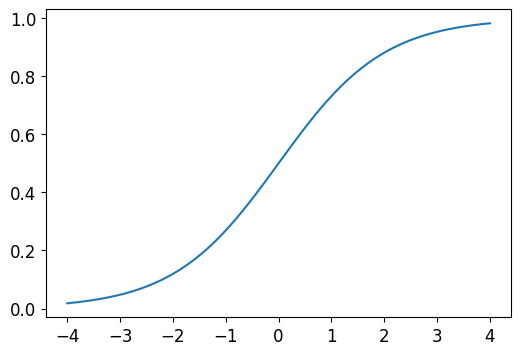

In [1]:
from fastbook import plot_function
import torch

plot_function(torch.sigmoid, min=-4, max=4)


If we have a classification model that classifies inputs into two output categories, represented by a single output, we can use the sigmoid function to process that logit, ensuring it falls between 0 and 1. There will actually be two outputs: $sigmoid(output)$ and $1-sigmoid(output)$.

Now, if we have $n$ outputs or activations, one per category (let's assume two for this example, and 6 rows of them for 6 input "items"):


In [2]:
torch.random.manual_seed(42)
logits = (
    torch.randn(6, 2) * 2
)  # seems like the book is scaling the random values a little bit like this
logits


tensor([[ 0.6734,  0.2576],
        [ 0.4689,  0.4607],
        [-2.2457, -0.3727],
        [ 4.4164, -1.2760],
        [ 0.9233,  0.5347],
        [ 1.0698,  1.6187]])

We cannot just take the sigmoid of this, because that won't give us values that add to 1:

In [3]:
logits.sigmoid()


tensor([[0.6623, 0.5641],
        [0.6151, 0.6132],
        [0.0957, 0.4079],
        [0.9881, 0.2182],
        [0.7157, 0.6306],
        [0.7446, 0.8346]])

What we can do is to take the difference of the values (representing how much more sure we are of the input being the thing represented in column 0 thing versus the thing represented in column 1) and *then* take the sigmoid of *that*. That will be the new column 0.

In [4]:
diff = logits[:, 0] - logits[:, 1]
diff


tensor([ 0.4158,  0.0083, -1.8731,  5.6924,  0.3886, -0.5489])

In [5]:
col0 = diff.sigmoid()
col0


tensor([0.6025, 0.5021, 0.1332, 0.9966, 0.5959, 0.3661])

Then, column 1 will be whatever the value needs to be for the sum of both columns to equal one. In other words, 1 - column 0:

In [6]:
col1 = 1 - col0
col1


tensor([0.3975, 0.4979, 0.8668, 0.0034, 0.4041, 0.6339])

Putting both columns together:

In [7]:
torch.stack([col0, col1], dim=1)


tensor([[0.6025, 0.3975],
        [0.5021, 0.4979],
        [0.1332, 0.8668],
        [0.9966, 0.0034],
        [0.5959, 0.4041],
        [0.3661, 0.6339]])

Now, according to the book that is equal to softmax.

### Why?


These are the implementations of sigmoid and softmax:

In [8]:
def sigmoid(x):
    return 1 / (1 + torch.exp(-x))


In [9]:
def softmax(x):
    return torch.exp(x) / torch.exp(x).sum(dim=1, keepdim=True)


Verify that they seem to work like the ones PyTorch provides:

In [10]:
act_1 = logits[0][0]
act_2 = logits[0][1]
(act_1, act_2)


(tensor(0.6734), tensor(0.2576))

In [11]:
assert sigmoid(act_1) == torch.sigmoid(act_1)


In [12]:
single_row_logits = torch.tensor((act_1, act_2)).unsqueeze(dim=0)
assert torch.allclose(
    softmax(single_row_logits), torch.softmax(single_row_logits, dim=1)
)


Applying the sigmoid formula to the first activation and calculating the second activation as $1-act_1$:

In [13]:
norm_1_sig = 1 / (1 + torch.exp(-act_1))
assert norm_1_sig == sigmoid(act_1)
norm_2_sig = 1 - 1 / (1 + torch.exp(-act_1))
assert norm_1_sig + norm_2_sig == 1
norm_1_sig, norm_2_sig


(tensor(0.6623), tensor(0.3377))

But see how the result of applying `softmax` is different:

In [14]:
softmax(torch.tensor([[act_1, act_2]]))


tensor([[0.6025, 0.3975]])

Here it's applied "manually":

In [15]:
torch.tensor([torch.exp(act_1), torch.exp(act_2)]) / torch.tensor(
    [torch.exp(act_1), torch.exp(act_2)]
).sum()


tensor([0.6025, 0.3975])

In [16]:
norm_1_soft = torch.exp(act_1) / (torch.exp(act_1) + torch.exp(act_2))
norm_2_soft = torch.exp(act_2) / (torch.exp(act_1) + torch.exp(act_2))
assert norm_1_soft + norm_2_soft == 1
norm_1_soft, norm_2_soft


(tensor(0.6025), tensor(0.3975))

OK, Sigmoid and Softmax produce different values that add to 1. (are they really different or is there an error here somewhere?)

In [17]:
softmax(torch.tensor([[0.02, 1.02, 0.22]]))


tensor([[0.2024, 0.5503, 0.2473]])